# US Immigration Data Model
### Data Engineering Capstone Project

#### Project Summary
This project creates an ETL pipeline to load data from various sources and clean and process the data into dimensional tables. The dimensional tables can be used to answer questions related to port of entry states from which immigrants were entering the United States, as well as details about the immigrants themselves. e.g. What is the median age in the state where the most migrants enter with a B2 visa type?

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
import pandas as pd
import configparser
from datetime import datetime
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, when, isnan, count
from datetime import datetime
from pyspark.sql.functions import year, month, dayofmonth, hour,\
    weekofyear, date_format, monotonically_increasing_id
from pyspark.sql.types import StructType as R, StructField as Fld,\
    DecimalType, DoubleType as Dbl, StringType as Str, IntegerType as Int,\
    TimestampType as Timestamp, DateType as Date, LongType as Long,\
    datetime as DateTime
import matplotlib.pyplot as plt

### Step 1: Scope the Project and Gather Data

#### Scope
The Udacity provided project has been used. This project creates an ETL pipeline that loads data from various sources into staging tables, then cleans and processes the data into a set of dimensional tables to be queried using Spark and Python (including Pyspark and Pandas). Input data - The immigration dataset from US I94 Immigration data, U.S. city demographic dataset from OpenSoft and world temperature dataset from Kaggle were used. Output data - Parquet files consisting of processed data in a Star Schema dimensional model.

#### Describe and Gather Data 
The following datasets were used:
* **I94 Immigration Data**: From the US National Tourism and Trade Office.
    * Data consists of US immigration data for 2016 (Jan - Dec)
    * Location: data/18-83510-I94-Data-2016
    * Link: https://travel.trade.gov/research/reports/i94/historical/2016.html
    * Description: A data dictionary is provided in the file I94_SAS_Labels_Descriptions.SAS
        * There is a file for each month of the year. An example file name is i94_apr16_sub.sas7bdat
        * There are 28 columns with information regarding arrival date, citizenship, country of residence, etc. 
 
 
* **I94 Country Codes**: From the US National Tourism and Trade Office.
    * Data consists of I94CIT codes from US immigration data for 2016 (Jan - Dec)
    * Location: data/country_codes_i94.csv
    * Link: https://travel.trade.gov/research/reports/i94/historical/2016.html
    * Description: Created from the data dictionary provided in the file I94_SAS_Labels_Descriptions.SAS
        * There is a single csv file
        * There are 2 columns with information regarding I94CIT code and country name. 


* **I94 Port Codes**: From the US National Tourism and Trade Office.
    * Data consists of I94PORT codes from US immigration data for 2016 (Jan - Dec)
    * Location: data/port_codes_i94.csv
    * Link: https://travel.trade.gov/research/reports/i94/historical/2016.html
    * Description: Created from the data dictionary provided in the file I94_SAS_Labels_Descriptions.SAS
        * There is a single csv file
        * There are 3 columns with information regarding I94PORT code, port name and port state. 


* **U.S. City Demographic Data**: From OpenSoft.
    * This data comes from the US Census Bureau's 2015 American Community Survey
    * Location: data/us-cities-demographics.csv
    * Link: https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/
    * Description: Demographics of all US cities and census-designated places with a population greater or equal to 65,000. 
        * There is a single csv file
        * There are 12 columns with information regarding city, state, median age, population, etc. 

### 1.1 Setup Config

In [2]:
# Read config file
config = configparser.ConfigParser()
config.read_file(open('dl.cfg'))

os.environ['AWS_ACCESS_KEY_ID'] = config['AWS_KEY']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = config['AWS_KEY']['AWS_SECRET_ACCESS_KEY']

# To use AWS storage, change the config paths below to use S3_DATA instead of DATA
input_data_immigration = config['DATA']['INPUT_DATA_IMMIGRATION'] 
input_data_countries = config['DATA']['INPUT_DATA_COUNTRIES']
input_data_ports = config['DATA']['INPUT_DATA_PORTS']
input_data_cities = config['DATA']['INPUT_DATA_CITIES']
output_data_staging = config['DATA']['OUTPUT_DATA_STAGING']
output_data_model = config['DATA']['OUTPUT_DATA_MODEL']
 
print('input_data_immigration path: {}'.format(input_data_immigration)) 
print('input_data_countries path: {}'.format(input_data_countries))
print('input_data_ports path: {}'.format(input_data_ports))
print('input_data_cities path: {}'.format(input_data_cities))
print('output_data_staging path: {}'.format(output_data_staging)) 
print('output_data_model path: {}'.format(output_data_model)) 

input_data_immigration path: ../../data/18-83510-I94-Data-2016/i94_jan16_sub.sas7bdat
input_data_countries path: data/country_codes_i94.csv
input_data_ports path: data/port_codes_i94.csv
input_data_cities path: data/us-cities-demographics.csv
output_data_staging path: data/output_data/staging/
output_data_model path: data/output_data/model/


### 1.2 Read in the data

In [3]:
# Read immigration data:
iterator = pd.read_sas(input_data_immigration, 'sas7bdat', encoding='ISO-8859-1',\
           chunksize=100000) 
immigration_df = next(iterator)

In [4]:
print(list(immigration_df.columns.values))
print(immigration_df.shape)
immigration_df.head()

['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa', 'count', 'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd', 'entdepu', 'matflag', 'biryear', 'dtaddto', 'gender', 'insnum', 'airline', 'admnum', 'fltno', 'visatype']
(100000, 28)


,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,7.0,2016.0,1.0,101.0,101.0,BOS,20465.0,1.0,MA,NaN,...,NaN,NaN,1996.0,D/S,M,NaN,LH,346608285.0,424,F1
1,8.0,2016.0,1.0,101.0,101.0,BOS,20465.0,1.0,MA,NaN,...,NaN,NaN,1996.0,D/S,M,NaN,LH,346627585.0,424,F1
2,9.0,2016.0,1.0,101.0,101.0,BOS,20469.0,1.0,CT,20480.0,...,NaN,M,1999.0,07152016,F,NaN,AF,381092385.0,338,B2
3,10.0,2016.0,1.0,101.0,101.0,BOS,20469.0,1.0,CT,20499.0,...,NaN,M,1971.0,07152016,F,NaN,AF,381087885.0,338,B2
4,11.0,2016.0,1.0,101.0,101.0,BOS,20469.0,1.0,CT,20499.0,...,NaN,M,2004.0,07152016,M,NaN,AF,381078685.0,338,B2


In [5]:
# Read Country data:
country_df = pd.read_csv(input_data_countries, header=0, sep=';')

In [6]:
print(list(country_df.columns.values))
print(country_df.shape)
country_df.head()

['i94cit', 'country_name']
(289, 2)


,i94cit,country_name
0,582,MEXICO
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


In [7]:
# Read Port data:
port_df = pd.read_csv(input_data_ports, header=0, sep=',')

In [8]:
print(list(port_df.columns.values))
print(port_df.shape)
port_df.head()

['i94port', 'port_name', 'port_state_code']
(660, 3)


,i94port,port_name,port_state_code
0,ALC,ALCAN,AK
1,ANC,ANCHORAGE,AK
2,BAR,BAKER AAF - BAKER ISLAND,AK
3,DAC,DALTONS CACHE,AK
4,PIZ,DEW STATION PT LAY DEW,AK


In [9]:
# Read city demographic code data:
city_demographic_df = pd.read_csv(input_data_cities, header=0, sep=';')

In [10]:
print(list(city_demographic_df.columns.values))
print(city_demographic_df.shape)
city_demographic_df.head()

['city', 'state', 'median_age', 'male_population', 'female_population', 'total_population', 'number_of_veterans', 'foreign_born', 'average_household_size', 'state_code', 'race', 'count']
(2891, 12)


,city,state,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,state_code,race,count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


### 1.3 Create a Spark Session

In [11]:
spark = SparkSession\
    .builder\
    .config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
    .enableHiveSupport().getOrCreate()  

### 1.4 Read input data into Spark

#### 1.4.1 Read immigration data into Spark

In [12]:
immigration_schema = R([
        Fld("cicid", Dbl(), False),
        Fld("i94yr", Dbl(), False),
        Fld("i94mon", Dbl(), False),
        Fld("i94cit", Dbl(), False),
        Fld("i94res", Dbl(), False),
        Fld("i94port", Str()),
        Fld("arrdate", Dbl()),
        Fld("i94mode", Dbl()),
        Fld("i94addr", Str()), 
        Fld("depdate", Dbl()), 
        Fld("i94bir", Dbl()),
        Fld("i94visa", Dbl()),
        Fld("count", Dbl()),
        Fld("dtadfile", Str()),
        Fld("visapost", Str()),
        Fld("occup", Str()),
        Fld("entdepa", Str()),
        Fld("entdepd", Str()),
        Fld("entdepu", Str()),
        Fld("matflag", Str()),
        Fld("biryear", Dbl()),
        Fld("dtaddto", Str()),
        Fld("gender", Str()),
        Fld("insnum", Str()),
        Fld("airline", Str()),
        Fld("admnum", Dbl()),
        Fld("fltno", Str()),
        Fld("visatype", Str())
    ])

In [13]:
#Read immigration data directly from sas files
#immigration_df_spark = spark.read.format('com.github.saurfang.sas.spark').load(input_data_immigration, schema=immigration_schema)
#Read immigration data from Pandas dataframe
immigration_df_spark = spark.createDataFrame(immigration_df, schema=immigration_schema)

#### 1.4.2 Read country data into Spark

In [14]:
country_schema = R([
        Fld("i94cit", Dbl()),
        Fld("country_name", Str()) 
    ])

In [15]:
countries_df_spark = spark.read.csv(input_data_countries, schema=country_schema,\
                     header="true", sep=";")

#### 1.4.3 Read port data into Spark

In [16]:
port_schema = R([ 
        Fld("i94port", Str()), 
        Fld("port_name", Str()),
        Fld("port_state_code", Str()) 
    ])

In [17]:
ports_df_spark = spark.read.csv(input_data_ports, schema=port_schema, header="true")

#### 1.4.4 Read city demographic data into Spark

In [18]:
 city_demographics_schema = R([
        Fld("city", Str(), False),
        Fld("state", Str(), False),
        Fld("median_age", Dbl()),
        Fld("male_population", Int()),
        Fld("female_population", Int()),
        Fld("total_population", Int()),
        Fld("number_of_veterans", Int()),
        Fld("foreign_born", Int()),
        Fld("average_household_size", Dbl()),
        Fld("state_code", Str()),
        Fld("race", Str()),
        Fld("count", Int()) 
    ])

In [19]:
 city_demographics_df_spark = spark.read.csv(input_data_cities,\
                              schema=city_demographics_schema, header="true", sep=";")

### 1.5 Write Spark data frames to output as Parquet files

In [20]:
timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M-%S-%f')
print(timestamp)

2020-04-02-14-24-36-877968


#### 1.5.1 Write Spark immigration data frames to output as Parquet files

In [21]:
#Write spark immigration data frame to parquet file
immigration_path = output_data_staging + "immigration_staging.parquet" + "_" + timestamp
print(f"Output Path: {immigration_path}")
immigration_df_spark.write.parquet(immigration_path, mode="overwrite") 

Output Path: data/output_data/staging/immigration_staging.parquet_2020-04-02-14-24-36-877968


In [22]:
#Read spark immigration data frame from parquet file 
immigration_df_spark = spark.read.parquet(immigration_path)
immigration_df_spark.printSchema()
immigration_df_spark.show(5)

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

#### 1.5.2 Write Spark country data frames to output as Parquet files

In [23]:
#Write spark countries data frame to parquet file
countries_path = output_data_staging + "countries_staging.parquet" + "_" + timestamp
print(f"Output Path: {countries_path}")
countries_df_spark.write.parquet(countries_path, mode="overwrite") 

Output Path: data/output_data/staging/countries_staging.parquet_2020-04-02-14-24-36-877968


In [24]:
#Read spark countries data frame from parquet file 
countries_df_spark = spark.read.parquet(countries_path)
countries_df_spark.printSchema()
countries_df_spark.show(5)

root
 |-- i94cit: double (nullable = true)
 |-- country_name: string (nullable = true)

+------+------------+
|i94cit|country_name|
+------+------------+
| 582.0|      MEXICO|
| 236.0| AFGHANISTAN|
| 101.0|     ALBANIA|
| 316.0|     ALGERIA|
| 102.0|     ANDORRA|
+------+------------+
only showing top 5 rows



#### 1.5.3 Write Spark port data frames to output as Parquet files

In [25]:
#Write spark ports data frame to parquet file
ports_path = output_data_staging + "ports_staging.parquet" + "_" + timestamp
print(f"Output Path: {ports_path}")
ports_df_spark.write.parquet(ports_path, mode="overwrite") 

Output Path: data/output_data/staging/ports_staging.parquet_2020-04-02-14-24-36-877968


In [26]:
#Read spark ports data frame from parquet file 
ports_df_spark = spark.read.parquet(ports_path)
ports_df_spark.printSchema()
ports_df_spark.show(5)

root
 |-- i94port: string (nullable = true)
 |-- port_name: string (nullable = true)
 |-- port_state_code: string (nullable = true)

+-------+--------------------+---------------+
|i94port|           port_name|port_state_code|
+-------+--------------------+---------------+
|    ALC|               ALCAN|             AK|
|    ANC|           ANCHORAGE|             AK|
|    BAR|BAKER AAF - BAKER...|             AK|
|    DAC|       DALTONS CACHE|             AK|
|    PIZ|DEW STATION PT LA...|             AK|
+-------+--------------------+---------------+
only showing top 5 rows



#### 1.5.4 Write Spark city_demographic data frames to output as Parquet files

In [27]:
#Write spark cities data frame to parquet file
city_demographics_path = output_data_staging + "city_demographics_staging.parquet" + "_" + timestamp
print(f"Output Path: {city_demographics_path}")
city_demographics_df_spark.write.parquet(city_demographics_path, mode="overwrite") 

Output Path: data/output_data/staging/city_demographics_staging.parquet_2020-04-02-14-24-36-877968


In [28]:
#Read spark cities data frame from parquet file
city_demographics_df_spark = spark.read.parquet(city_demographics_path)
city_demographics_df_spark.printSchema()
city_demographics_df_spark.show(5)

root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- median_age: double (nullable = true)
 |-- male_population: integer (nullable = true)
 |-- female_population: integer (nullable = true)
 |-- total_population: integer (nullable = true)
 |-- number_of_veterans: integer (nullable = true)
 |-- foreign_born: integer (nullable = true)
 |-- average_household_size: double (nullable = true)
 |-- state_code: string (nullable = true)
 |-- race: string (nullable = true)
 |-- count: integer (nullable = true)

+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|            city|        state|median_age|male_population|female_population|total_population|number_of_veterans|foreign_born|average_household_size|state_code|                race|count|
+----------------+-------------+----------+---------------+-----------------+-------------

### Step 2: Explore and Assess the Data
#### 2.1 Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.


The following Data Quality issues were discovered in the data:
* I94 Immigration Data:
    * Missing data (either Null or NaN) values found for 9 columns
    * depdate should be excluded from cleansing as Null values are allowed
    
* I94 Country Codes data: 
    * No data quality issues found
    
* I94 Port Codes data: 
    * Missing data (either Null or NaN) values found for port_state_code column
    
* U.S. City Demographic Data data:
    * Missing data (either Null or NaN) values found for 5 columns

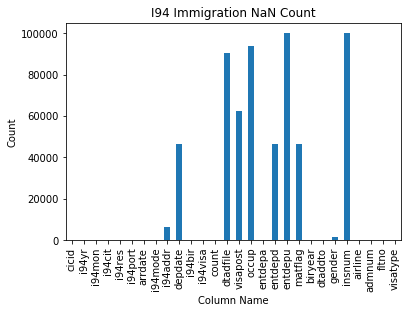

In [29]:
immigration_df_spark.select([count(when(isnan(c), c)).alias(c) for c in 
    immigration_df_spark.columns]).toPandas().T.plot(kind='bar', legend=False) 
plt.xlabel('Column Name')
plt.ylabel('Count')
plt.title("I94 Immigration NaN Count") 
plt.show()

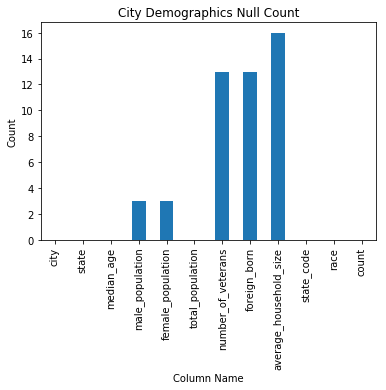

In [30]:
city_demographics_df_spark.select([count(when(col(c).isNull(), c)).alias(c) for c in 
    city_demographics_df_spark.columns]).toPandas().T.plot(kind='bar', legend=False) 
plt.xlabel('Column Name')
plt.ylabel('Count')
plt.title("City Demographics Null Count") 
plt.show()

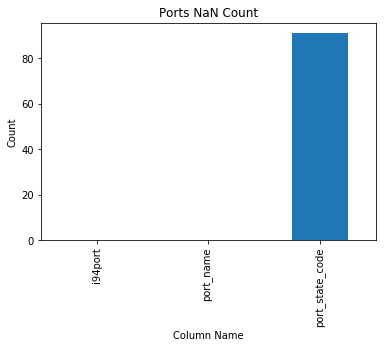

In [31]:
ports_df_spark.select([count(when(isnan(c), c)).alias(c) for c in 
    ports_df_spark.columns]).toPandas().T.plot(kind='bar', legend=False) 
plt.xlabel('Column Name')
plt.ylabel('Count')
plt.title("Ports NaN Count") 
plt.show()

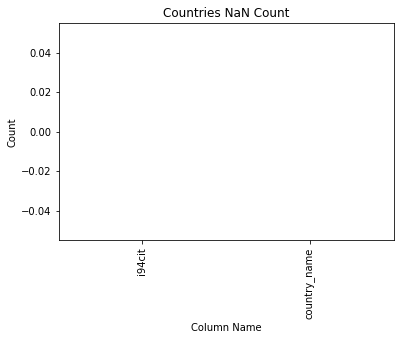

In [32]:
countries_df_spark.select([count(when(isnan(c), c)).alias(c) for c in 
    countries_df_spark.columns]).toPandas().T.plot(kind='bar', legend=False) 
plt.xlabel('Column Name')
plt.ylabel('Count')
plt.title("Countries NaN Count") 
plt.show()

#### 2.2 Cleaning Steps
Document steps necessary to clean the data

The following Data Cleansing steps need to be applied to clean the data:
* I94 Immigration data:
    * NaN values will be replaced by either NA (string), or 0.0 (double)
    * i94addr field with NaN values will be replaced by 99, which represents 'All Other Codes'
    
* I94 Port Codes data:  
    * port_state_code field with NaN values will be replaced by XXX, which represents 'NOT REPORTED/UNKNOWN'
    
* U.S. City Demographic data: 
    * Null values will be replaced by either NA (string), 0 (integer) or 0.0 (double)

#### 2.2.1 Clean I94 immigration data

In [33]:
immigration_df_spark_clean = immigration_df_spark.withColumn('depdate',\
                             when(isnan('depdate'),0.0).otherwise(col("depdate")))
immigration_df_spark_clean = immigration_df_spark_clean.withColumn('i94addr',\
                             when(isnan('i94addr'),'99').otherwise(col("i94addr")))

columns = ['dtadfile','visapost','occup','entdepd','entdepu','matflag','insnum']
for column in columns:
    immigration_df_spark_clean = immigration_df_spark_clean.withColumn(column,\
                                 when(isnan(col(column)),'NA').otherwise(col(column)))
immigration_df_spark_clean.show(5)   

+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+------------+-----+--------+
|cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|      admnum|fltno|visatype|
+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+------------+-----+--------+
|  7.0|2016.0|   1.0| 101.0| 101.0|    BOS|20465.0|    1.0|     MA|    0.0|  20.0|    3.0|  1.0|      NA|      NA|   NA|      T|     NA|     NA|     NA| 1996.0|     D/S|     M|    NA|     LH|3.46608285E8|  424|      F1|
|  8.0|2016.0|   1.0| 101.0| 101.0|    BOS|20465.0|    1.0|     MA|    0.0|  20.0|    3.0|  1.0|      NA|      NA|   NA|

In [34]:
#Convert date fields from SAS format to YYYY-MM-DD format
epoch = DateTime.datetime(1960, 1, 1) 
get_date = udf(lambda x: epoch + DateTime.timedelta(days=x),Date())

immigration_df_spark_clean = immigration_df_spark_clean\
                             .withColumn('arrdate', get_date('arrdate'))\
                             .withColumn('depdate', get_date('depdate'))

#Reset previous depdate Null values
immigration_df_spark_clean = immigration_df_spark_clean\
                             .withColumn('depdate', when(col("depdate") == "1960-01-01", "NULL")\
                             .otherwise(col("depdate"))) 
immigration_df_spark_clean.show(5)   

+-----+------+------+------+------+-------+----------+-------+-------+----------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+------------+-----+--------+
|cicid| i94yr|i94mon|i94cit|i94res|i94port|   arrdate|i94mode|i94addr|   depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|      admnum|fltno|visatype|
+-----+------+------+------+------+-------+----------+-------+-------+----------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+------------+-----+--------+
|  7.0|2016.0|   1.0| 101.0| 101.0|    BOS|2016-01-12|    1.0|     MA|      NULL|  20.0|    3.0|  1.0|      NA|      NA|   NA|      T|     NA|     NA|     NA| 1996.0|     D/S|     M|    NA|     LH|3.46608285E8|  424|      F1|
|  8.0|2016.0|   1.0| 101.0| 101.0|    BOS|2016-01-12|    1.0|     MA|      NULL|  20.0|    3.0|

#### 2.2.2 Clean I94 port data

In [35]:
ports_df_spark_clean = ports_df_spark\
                       .withColumn('port_state_code',when(isnan('port_state_code'),'XXX')\
                       .otherwise(col("port_state_code")))
ports_df_spark_clean.show(5)  

+-------+--------------------+---------------+
|i94port|           port_name|port_state_code|
+-------+--------------------+---------------+
|    ALC|               ALCAN|             AK|
|    ANC|           ANCHORAGE|             AK|
|    BAR|BAKER AAF - BAKER...|             AK|
|    DAC|       DALTONS CACHE|             AK|
|    PIZ|DEW STATION PT LA...|             AK|
+-------+--------------------+---------------+
only showing top 5 rows



#### 2.2.3 Clean I94 city_demographic data

In [36]:
city_demographics_df_spark_clean = city_demographics_df_spark\
                                   .withColumn('average_household_size',when(col('average_household_size').isNull(),0.0)\
                                   .otherwise(col("average_household_size")))

columns = ['male_population','female_population','foreign_born','number_of_veterans']
for column in columns:
    city_demographics_df_spark_clean = city_demographics_df_spark_clean\
                                       .withColumn(column,when(col(column).isNull(),0)\
                                       .otherwise(col(column)))

city_demographics_df_spark_clean.show(5) 

+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|            city|        state|median_age|male_population|female_population|total_population|number_of_veterans|foreign_born|average_household_size|state_code|                race|count|
+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|   Silver Spring|     Maryland|      33.8|          40601|            41862|           82463|              1562|       30908|                   2.6|        MD|  Hispanic or Latino|25924|
|          Quincy|Massachusetts|      41.0|          44129|            49500|           93629|              4147|       32935|                  2.39|        MA|               White|58723|
|          Hoover|      Alabama|      38.5|          38040| 

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

The immigration model is a star schema dimensional data model with 1 fact table and 3 dimension tables.
The star schema was chosen to allow for quick querying of the data through de-normalized tables,
which are easier for business users to understand.

* Fact table:
 * fact_immigration
   * Primary key: immigration_id
   * Foreign keys: arrival_date, port_state_code, admission_number
  
      
* Dimension tables:
 * dim_admissions
   * Primary key: admission_number 
 * dim_state_demographics
   * Primary key: State_Code 
 * dim_date
   * Primary key: date 
      
![Immigration Model - Dimensional Tables](./dimensional_tables.png)


![Immigration Model - Staging Tables](./staging_tables.png)

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

To build the model, a python script 'etl.py' needs to be run.

Below is the description of steps to pipeline the data in the python file:
 1. Read dl.cfg config file to retrieve file paths and AWS access keys if required.
 2. i94 immigration data and U.S. city demographic data is read into Pandas dataframes, which are then read into Spark dataframes and then stored as     staging tables in parquet format.
 3. Staging parquet files are read into Spark dataframes, data is cleaned, aggregated and joined where required to create the dimensional tables,         which are also stored in parquet format.
 4. dim_state_demographics is created first by aggregating the city_demographic staging table.
 5. dim_admissions is created next by joining the immigrations staging table to the countries staging table and selecting required columns.
 6. dim_date is then created by retrieving and converting every arrival date in the immigrations staging table.
 7. fact_immigrations is created last from the immigrations staging table.
 8. Once the dimensional tables have been created, data quality checks are performed to ensure the pipline ran as expected. 

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [37]:
timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M-%S-%f')
print(timestamp)

2020-04-02-14-25-08-128290


##### 4.1.1 dim_state_demographics

In [38]:
city_demographics_df_spark_clean.createOrReplaceTempView("dim_state_demographics")
dim_state_demographics = spark.sql("""
    SELECT distinct
        State_Code,
        State,
        avg(median_age) as median_age,
        sum(male_population) as male_population,
        sum(female_population) as female_population,
        sum(total_population) as total_population,
        avg(average_household_size) as average_household_size
    FROM 
        dim_state_demographics
    group by
        State_Code,
        State
    order by State
""") 
dim_state_demographics = dim_state_demographics\
                        .withColumn("median_age", dim_state_demographics["median_age"]\
                        .cast(DecimalType(9,2)))\
                        .withColumn("average_household_size", dim_state_demographics["average_household_size"]\
                        .cast(DecimalType(9,2))) 
dim_state_demographics.printSchema()
dim_state_demographics.show(5)

root
 |-- State_Code: string (nullable = true)
 |-- State: string (nullable = true)
 |-- median_age: decimal(9,2) (nullable = true)
 |-- male_population: long (nullable = true)
 |-- female_population: long (nullable = true)
 |-- total_population: long (nullable = true)
 |-- average_household_size: decimal(9,2) (nullable = true)

+----------+----------+----------+---------------+-----------------+----------------+----------------------+
|State_Code|     State|median_age|male_population|female_population|total_population|average_household_size|
+----------+----------+----------+---------------+-----------------+----------------+----------------------+
|        AL|   Alabama|     36.16|        2448200|          2715106|         5163306|                  2.43|
|        AK|    Alaska|     32.20|         764725|           728750|         1493475|                  2.77|
|        AZ|   Arizona|     35.04|       11137275|         11360435|        22497710|                  2.77|
|        AR|  A

In [39]:
#Write dim_state_demographics to parquet file
dim_state_demographics_path = output_data_model + "dim_state_demographics.parquet" + "_" + timestamp
print(f"Output Path: {dim_state_demographics_path}")
dim_state_demographics.write.parquet(dim_state_demographics_path, mode="overwrite") 

Output Path: data/output_data/model/dim_state_demographics.parquet_2020-04-02-14-25-08-128290


##### 4.1.2 dim_admissions

In [40]:
admissions_df_spark = immigration_df_spark_clean.join(countries_df_spark, \
    (immigration_df_spark_clean.i94cit == countries_df_spark.i94cit))

In [41]:
admissions_df_spark.createOrReplaceTempView("dim_admissions")
dim_admissions = spark.sql("""
    SELECT distinct
        admnum as admission_number,
        country_name,
        i94bir as age,
        i94visa as visa_code,
        gender,
        visatype
    FROM 
        dim_admissions
""") 
dim_admissions.printSchema()
dim_admissions.show(5)

root
 |-- admission_number: double (nullable = true)
 |-- country_name: string (nullable = true)
 |-- age: double (nullable = true)
 |-- visa_code: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- visatype: string (nullable = true)

+----------------+------------+----+---------+------+--------+
|admission_number|country_name| age|visa_code|gender|visatype|
+----------------+------------+----+---------+------+--------+
|    2.90550485E8|     AUSTRIA|54.0|      1.0|     M|      WB|
|    3.04135485E8|     AUSTRIA|29.0|      3.0|     F|      F1|
|    4.42585085E8|     BELGIUM|20.0|      2.0|     M|      B2|
|    3.01033485E8|    BULGARIA|24.0|      3.0|     F|      F1|
|    3.16043985E8|      POLAND|29.0|      1.0|     M|      B1|
+----------------+------------+----+---------+------+--------+
only showing top 5 rows



In [42]:
#Write dim_admissions to parquet file
dim_admissions_path = output_data_model + "dim_admissions.parquet" + "_" + timestamp
print(f"Output Path: {dim_admissions_path}")
dim_admissions.write.parquet(dim_admissions_path, mode="overwrite") 

Output Path: data/output_data/model/dim_admissions.parquet_2020-04-02-14-25-08-128290


##### 4.1.3 dim_date

In [43]:
immigration_df_spark_clean.createOrReplaceTempView("dim_date")
dim_date = spark.sql("""
    SELECT distinct
        arrdate as date,
        day(arrdate) as day, 
        month(arrdate) as month,
        year(arrdate) as year,
        weekofyear(arrdate) as week,
        dayofweek(arrdate) as weekday
    FROM 
        dim_date
""") 
dim_date.printSchema()
dim_date.show(5)

root
 |-- date: date (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- weekday: integer (nullable = true)

+----------+---+-----+----+----+-------+
|      date|day|month|year|week|weekday|
+----------+---+-----+----+----+-------+
|2016-01-16| 16|    1|2016|   2|      7|
|2016-01-03|  3|    1|2016|  53|      1|
|2016-01-14| 14|    1|2016|   2|      5|
|2016-01-07|  7|    1|2016|   1|      5|
|2016-01-10| 10|    1|2016|   1|      1|
+----------+---+-----+----+----+-------+
only showing top 5 rows



In [44]:
#Write dim_date to parquet file
dim_date_path = output_data_model + "dim_date.parquet" + "_" + timestamp
print(f"Output Path: {dim_date_path}")
dim_date.write.parquet(dim_date_path, mode="overwrite") 

Output Path: data/output_data/model/dim_date.parquet_2020-04-02-14-25-08-128290


##### 4.1.4 fact_immigrations

In [45]:
immigration_df_spark_joined = immigration_df_spark_clean.join(ports_df_spark_clean, \
(immigration_df_spark_clean.i94port == ports_df_spark_clean.i94port))

In [46]:
immigration_df_spark_joined = immigration_df_spark_joined\
                              .withColumn("immigration_id", monotonically_increasing_id()) 

In [47]:
immigration_df_spark_joined.createOrReplaceTempView("fact_immigrations")
fact_immigrations = spark.sql("""
    SELECT distinct
        immigration_id,
        arrdate as arrival_date,
        port_name,
        port_state_code,
        i94mode as mode_of_transport,
        i94addr local_address_state_code,
        depdate as departure_date,
        admnum as admission_number,
        airline,
        fltno as flight_number
    FROM 
        fact_immigrations
""") 
fact_immigrations.printSchema()
fact_immigrations.show(5)

root
 |-- immigration_id: long (nullable = false)
 |-- arrival_date: date (nullable = true)
 |-- port_name: string (nullable = true)
 |-- port_state_code: string (nullable = true)
 |-- mode_of_transport: double (nullable = true)
 |-- local_address_state_code: string (nullable = true)
 |-- departure_date: string (nullable = true)
 |-- admission_number: double (nullable = true)
 |-- airline: string (nullable = true)
 |-- flight_number: string (nullable = true)

+--------------+------------+---------------+---------------+-----------------+------------------------+--------------+----------------+-------+-------------+
|immigration_id|arrival_date|      port_name|port_state_code|mode_of_transport|local_address_state_code|departure_date|admission_number|airline|flight_number|
+--------------+------------+---------------+---------------+-----------------+------------------------+--------------+----------------+-------+-------------+
|           523|  2016-01-09|         BOSTON|             M

In [48]:
#Write fact_immigrations to parquet file
fact_immigrations_path = output_data_model + "fact_immigrations.parquet" + "_" + timestamp
print(f"Output Path: {fact_immigrations_path}")
fact_immigrations.write.parquet(fact_immigrations_path, mode="overwrite") 

Output Path: data/output_data/model/fact_immigrations.parquet_2020-04-02-14-25-08-128290


#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
The following Data Quality checks will be applied:
 * All dimensional tables should have data populated (Rowcount > 0)
 * Integrity constraints - Foreign keys and their associated Primary keys should be populated. 

In [49]:
data_quality_check = { "timestamp": timestamp,
            "dim_state_demographics_count": 0,
            "dim_state_demographics_check": "",
            "dim_admissions_count": 0,
            "dim_admissions_check": "",
            "dim_date_count": 0, 
            "dim_date_check": "",
            "fact_immigrations_count": 0,
            "fact_immigrations_check": "" }

#### 4.2.1 Check state_demographics data

In [50]:
dim_state_demographics.createOrReplaceTempView("dim_state_demographics_check")
dim_state_demographics_check_count = spark.sql("""
    SELECT
        count(1) as count
    FROM 
        dim_state_demographics_check
""")
dim_state_demographics_check_count.collect()[0][0]

49

In [51]:
dim_state_demographics.createOrReplaceTempView("dim_state_demographics_check")
dim_state_demographics_check_missing = spark.sql("""
    SELECT distinct
        count(1) as count
    FROM 
        dim_state_demographics_check
    where
        state_code IS NULL or state_code == "" or state_code == "NaN"
""")
dim_state_demographics_check_missing.collect()[0][0]

0

In [52]:
if dim_state_demographics_check_count.collect()[0][0] < 1 or \
   dim_state_demographics_check_missing.collect()[0][0] > 0:
    data_quality_check['dim_state_demographics_count'] = dim_state_demographics_check_count.collect()[0][0]
    data_quality_check['dim_state_demographics_check'] = "NOK"
else:
    data_quality_check['dim_state_demographics_count'] = dim_state_demographics_check_count.collect()[0][0]
    data_quality_check['dim_state_demographics_check'] = "OK"
    
data_quality_check

{'timestamp': '2020-04-02-14-25-08-128290',
 'dim_state_demographics_count': 49,
 'dim_state_demographics_check': 'OK',
 'dim_admissions_count': 0,
 'dim_admissions_check': '',
 'dim_date_count': 0,
 'dim_date_check': '',
 'fact_immigrations_count': 0,
 'fact_immigrations_check': ''}

#### 4.2.2 Check dim_admissions data

In [53]:
dim_admissions.createOrReplaceTempView("dim_admissions_check")
dim_admissions_check_count = spark.sql("""
    SELECT
        count(1) as count
    FROM 
        dim_admissions_check
""")
dim_admissions_check_count.collect()[0][0]

92279

In [54]:
dim_admissions.createOrReplaceTempView("dim_admissions_check")
dim_admissions_check_missing = spark.sql("""
    SELECT distinct
        count(1) as count
    FROM 
        dim_admissions_check
    where
        admission_number IS NULL or admission_number == "" or admission_number == "NaN" or admission_number = 0.0
""")
dim_admissions_check_missing.collect()[0][0]

0

In [55]:
if dim_admissions_check_count.collect()[0][0] < 1 or \
   dim_admissions_check_missing.collect()[0][0] > 0:
    data_quality_check['dim_admissions_count'] = dim_admissions_check_count.collect()[0][0]
    data_quality_check['dim_admissions_check'] = "NOK"
else:
    data_quality_check['dim_admissions_count'] = dim_admissions_check_count.collect()[0][0]
    data_quality_check['dim_admissions_check'] = "OK"
    
data_quality_check

{'timestamp': '2020-04-02-14-25-08-128290',
 'dim_state_demographics_count': 49,
 'dim_state_demographics_check': 'OK',
 'dim_admissions_count': 92279,
 'dim_admissions_check': 'OK',
 'dim_date_count': 0,
 'dim_date_check': '',
 'fact_immigrations_count': 0,
 'fact_immigrations_check': ''}

#### 4.2.3 Check dim_date data

In [56]:
dim_date.createOrReplaceTempView("dim_date_check")
dim_date_check_count = spark.sql("""
    SELECT
        count(1) as count
    FROM 
       dim_date_check
""")
dim_date_check_count.collect()[0][0]

31

In [57]:
if dim_date_check_count.collect()[0][0] < 1:
    data_quality_check['dim_date_count'] = dim_date_check_count.collect()[0][0]
    data_quality_check['dim_date_check'] = "NOK"
else:
    data_quality_check['dim_date_count'] = dim_date_check_count.collect()[0][0]
    data_quality_check['dim_date_check'] = "OK"
    
data_quality_check

{'timestamp': '2020-04-02-14-25-08-128290',
 'dim_state_demographics_count': 49,
 'dim_state_demographics_check': 'OK',
 'dim_admissions_count': 92279,
 'dim_admissions_check': 'OK',
 'dim_date_count': 31,
 'dim_date_check': 'OK',
 'fact_immigrations_count': 0,
 'fact_immigrations_check': ''}

#### 4.2.4 Check fact_immigrations data

In [58]:
fact_immigrations.createOrReplaceTempView("fact_immigrations_check")
fact_immigrations_check_count = spark.sql("""
    SELECT
        count(1) as count
    FROM 
        fact_immigrations_check
""")
fact_immigrations_check_count.collect()[0][0]

100000

In [59]:
fact_immigrations.createOrReplaceTempView("fact_immigrations_check")
fact_immigrations_check_missing = spark.sql("""
    SELECT distinct
        count(1) as count
    FROM 
        fact_immigrations_check
    where
        arrival_date IS NULL or arrival_date == "" or arrival_date == "NaN" or
        port_state_code IS NULL or port_state_code == "" or port_state_code == "NaN" or
        admission_number IS NULL or admission_number == "" or admission_number == "NaN" or admission_number = 0.0
""")
fact_immigrations_check_missing.collect()[0][0]

0

In [60]:
if fact_immigrations_check_count.collect()[0][0] < 1 or\
   fact_immigrations_check_missing.collect()[0][0] > 0:
    data_quality_check['fact_immigrations_count'] = fact_immigrations_check_count.collect()[0][0]
    data_quality_check['fact_immigrations_check'] = "NOK"
else:
    data_quality_check['fact_immigrations_count'] = fact_immigrations_check_count.collect()[0][0]
    data_quality_check['fact_immigrations_check'] = "OK"
    
data_quality_check

{'timestamp': '2020-04-02-14-25-08-128290',
 'dim_state_demographics_count': 49,
 'dim_state_demographics_check': 'OK',
 'dim_admissions_count': 92279,
 'dim_admissions_check': 'OK',
 'dim_date_count': 31,
 'dim_date_check': 'OK',
 'fact_immigrations_count': 100000,
 'fact_immigrations_check': 'OK'}

#### 4.3 Data dictionary 
Create a data dictionary for your data model. 

##### dim_state_demographics
Dimension Table: dim_state_demographics

Provides population statistics on states in the U.S.
The data was aggregated from city demographic data to state level.

* State_Code: Primary key. Two-digit alphabetic code to define the state
* State: Name of the state in U.S.
* median_age: Median age of the population in the state
* male_population: Number of men in the state
* female_population: Number of women in the state
* total_population: Number of people in the state
* average_household_size: Average size of households in the state 



##### dim_admissions
Dimension Table: dim_admissions

Provides details of immigrants admitted into the U.S.
The data was processed from the original I94 Immigrations data.
 
* admission_number: Primary key. U.S. admission number provided when entering the country
* country_name: Name of the country of citizenship
* age: Age of person entering the country
* visa_code: Code of visa categories: 1=Business, 2=Business, 3=Student.
* gender: Non-immigrant sex 
* visatype: Class of admission legally admitting the non-immigrant to temporarily stay in U.S.



##### dim_date
Dimension Table: dim_date

Provides details of immigration date events.
The data was extracted from the original I94 Immigrations data.
 
* date: Primary key. Date when person was granted entry into the U.S.
* day: Day of the month from the date field (Numeric)
* month: Month of the year from the date field (Numeric)
* year: Year from the date field. 
* week: Week of the month from the date field (Numeric) 
* weekday: Day of the week from the date field (Numeric)



##### fact_immigration

Provides details of immigration events.
The data was processed from the original I94 Immigrations data.

* immigration_id: Primary key. Unique ID generated for an immigration event.
* arrival_date: Date of arrival into the country
* port_name: Name of the port of entry
* port_state_code: Two-digit alphabetic code to define the state of the port of entry
* mode_of_transport:  Mode of transport for entry: 1=Air, 2=Sea, 3=Land, 9=Not reported.
* local_address_state_code: Two-digit alphabetic code to define the state where immigrant is staying
* departure_date: Date of departure from the country. Null indicates the person has not departed yet
* admission_number: U.S. admission number provided when entering the country
* airline: Airline used to enter the country
* flight_number: Flight number of the airline used to enter the country

#### Step 5: Complete Project Write Up

Clearly state the rationale for the choice of tools and technologies for the project.
 * Python (with Pandas and PySpark libraries) were used to import and process the data. Python has rich libraries and Spark is very fast at    processing data. Together, they had all the necessary functionality to quickly and fairly easily import, analyze and process large datasets.

Propose how often the data should be updated and why.
 * I would suggest once a month, as it seems new 194 immigration datasets are released every month.

Write a description of how you would approach the problem differently under the following scenarios:
 1. The data was increased by 100x. 
  * The input and output data should be stored on cloud storage, such as AWS S3.
  * Spark on a distributed cluster should be used to process the data.
  * Staging and dimensional tables should be stored on a cloud data warehouse, such as AWS Redshift. 


 2. The data populates a dashboard that must be updated on a daily basis by 7am every day.
  * Keep a subset of data for the latest month to be processed separately and scheduled to run daily through an Airflow DAG.


 3. The database needed to be accessed by 100+ people.
  * The input and output data should be stored on cloud storage, such as AWS S3.
  * Staging and dimensional tables should be stored on a cloud data warehouse, such as AWS Redshift. 
  * Consider replication to nodes closer to the users to improve access speed.